In [1]:
import sys
import os
import datetime
import calendar
import csv
import time
import subprocess
import logging as log

from pyspark import SparkContext, SparkConf, Row
from pyspark.sql import SQLContext, HiveContext, SparkSession
import getpass
from datetime import timedelta, date
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.sql.functions import udf, lit, col, coalesce
import pyspark.sql.functions as F
from pyspark.sql.types import *
from subprocess import call
import pandas as pd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import functools
from sklearn.metrics import roc_curve, auc
from pyspark.ml.feature import OneHotEncoder
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
df = spark.read.csv('dell_case_study.csv', header=True)

In [3]:
df.show(5)

+----------+-----------+-----------+--------+-----------+-----------+---------+--------+--------------+--------+
|prod_price|prod_feat_1|prod_feat_2|cust_age|prod_feat_3|cust_region|prod_type|cust_sex|    cust_title|feedback|
+----------+-----------+-----------+--------+-----------+-----------+---------+--------+--------------+--------+
|      1000|        1.2|        0.2|      34|          A|      south|     Home|       M|       manager|     pos|
|     230.5|        3.3|       0.43|    null|          C|      south|     Home|       M|      director|     pos|
|       121|       22.3|       1.01|      56|          D|      north| Cleaning|       F|      engineer| Neutral|
|       628|        2.2|       0.86|      34|          V|       west|   Beauty|       M|      director|Negetive|
|       887|       35.6|       1.08|      43|          A|      south| Cleaning|       F|senior_manager|     pos|
+----------+-----------+-----------+--------+-----------+-----------+---------+--------+--------

In [4]:
type(df)

pyspark.sql.dataframe.DataFrame

In [5]:
df.printSchema()

root
 |-- prod_price: string (nullable = true)
 |-- prod_feat_1: string (nullable = true)
 |-- prod_feat_2: string (nullable = true)
 |-- cust_age: string (nullable = true)
 |-- prod_feat_3: string (nullable = true)
 |-- cust_region: string (nullable = true)
 |-- prod_type: string (nullable = true)
 |-- cust_sex: string (nullable = true)
 |-- cust_title: string (nullable = true)
 |-- feedback: string (nullable = true)



([<matplotlib.axis.XTick at 0x113c84710>,
 <a list of 3 Text xticklabel objects>)

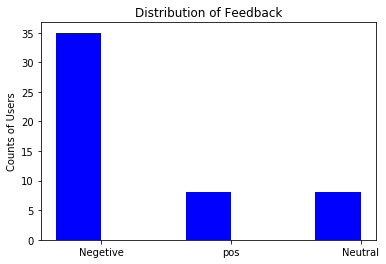

In [6]:
#Q1) Responses distribution and visualizing Skewed responses
 
feedback_distribution = df.groupBy('feedback').count().collect()
fb_type = [i[0] for i in feedback_distribution]
counts = [i[1] for i in feedback_distribution]
 
ind = np.array(range(len(fb_type)))
width = 0.35
plt.bar(ind, counts, width=width, color='b')
 
plt.ylabel('Counts of Users')
plt.title('Distribution of Feedback')
plt.xticks(ind + width/2., fb_type)


In [7]:
# since its assumed that data is skwed towards negetive feedback 
# hence here we can combine pos and neutral feedback together

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
combine = lambda x: 'pos' if x == 'Neutral' else x
 
udfcombine = udf(combine, StringType())
df = df.withColumn("binary_response", udfcombine("feedback"))

In [8]:
df.show(10)

+----------+-----------+-----------+--------+-----------+-----------+---------+--------+--------------+--------+---------------+
|prod_price|prod_feat_1|prod_feat_2|cust_age|prod_feat_3|cust_region|prod_type|cust_sex|    cust_title|feedback|binary_response|
+----------+-----------+-----------+--------+-----------+-----------+---------+--------+--------------+--------+---------------+
|      1000|        1.2|        0.2|      34|          A|      south|     Home|       M|       manager|     pos|            pos|
|     230.5|        3.3|       0.43|    null|          C|      south|     Home|       M|      director|     pos|            pos|
|       121|       22.3|       1.01|      56|          D|      north| Cleaning|       F|      engineer| Neutral|            pos|
|       628|        2.2|       0.86|      34|          V|       west|   Beauty|       M|      director|Negetive|       Negetive|
|       887|       35.6|       1.08|      43|          A|      south| Cleaning|       F|senior_ma

In [9]:
# Q2)Filling NA values and casting data types
# there are float, int and string data type which we can cast to the different columns.

column_list = ['prod_price',
               'prod_feat_1',
               'prod_feat_2',
               'cust_age',
               'prod_feat_3',
               'cust_region',
               'prod_type',
               'cust_sex',
               'cust_title',
               'feedback',
               'binary_response']

# Numerical columns areconverted to float values and integer
# last columns from 4 to 11 are all string type 

df = df.select(df.prod_price.cast('float'), 
               df.prod_feat_1.cast('float'),
               df.prod_feat_2.cast('float'),
               df.cust_age.cast('int'),
               *column_list[4:])

# the missing values are filled with NA values 

df = df.fillna({'cust_region': 'NA', 'cust_title': 'NA', 'prod_type': 'NA'})


In [10]:
df.printSchema()

root
 |-- prod_price: float (nullable = true)
 |-- prod_feat_1: float (nullable = true)
 |-- prod_feat_2: float (nullable = true)
 |-- cust_age: integer (nullable = true)
 |-- prod_feat_3: string (nullable = true)
 |-- cust_region: string (nullable = false)
 |-- prod_type: string (nullable = false)
 |-- cust_sex: string (nullable = true)
 |-- cust_title: string (nullable = false)
 |-- feedback: string (nullable = true)
 |-- binary_response: string (nullable = true)



In [11]:
df.show(10)

+----------+-----------+-----------+--------+-----------+-----------+---------+--------+--------------+--------+---------------+
|prod_price|prod_feat_1|prod_feat_2|cust_age|prod_feat_3|cust_region|prod_type|cust_sex|    cust_title|feedback|binary_response|
+----------+-----------+-----------+--------+-----------+-----------+---------+--------+--------------+--------+---------------+
|    1000.0|        1.2|        0.2|      34|          A|      south|     Home|       M|       manager|     pos|            pos|
|     230.5|        3.3|       0.43|    null|          C|      south|     Home|       M|      director|     pos|            pos|
|     121.0|       22.3|       1.01|      56|          D|      north| Cleaning|       F|      engineer| Neutral|            pos|
|     628.0|        2.2|       0.86|      34|          V|       west|   Beauty|       M|      director|Negetive|       Negetive|
|     887.0|       35.6|       1.08|      43|          A|      south| Cleaning|       F|senior_ma

In [12]:
# Q3)Check for categorical column that has too many discrete values
# below code gives the value count of all the columns with discrete values

for column in df.columns[4:-2]:
    print(column, df.select(column).distinct().count())

prod_feat_3 18
cust_region 5
prod_type 7
cust_sex 2
cust_title 8


In [13]:
#prod_feat_3 has the highest number of discrete values ie 18

prodFeat3_Count = df.groupBy("prod_feat_3").count()
prodFeat3_Count.show()

+-----------+-----+
|prod_feat_3|count|
+-----------+-----+
|          K|    1|
|          F|    5|
|          E|    1|
|          T|    2|
|          B|    4|
|          Y|    2|
|          V|    3|
|          U|    1|
|          D|    5|
|          C|    3|
|          J|    1|
|          A|    4|
|          N|    3|
|          X|    2|
|          S|    4|
|          R|    2|
|          G|    4|
|          H|    4|
+-----------+-----+



In [14]:
# Q4)Group all the categories that rank lower than a threshold(assume) into one category, namely “MinorityCategory”

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
# Here we choose the threshold value as 3
thresholdValue = 3  

prodFeat3_Count = df.groupBy("prod_feat_3").count()
df = df.join(prodFeat3_Count, "prod_feat_3", "inner")
 
def changeMinValuesCat(originalColumn, columnCount):
    if columnCount > thresholdValue:
        return originalColumn
    else:
        return 'MinorityCategory'
    
udfmakeNewCol = udf(changeMinValuesCat, StringType())
df = df.withColumn('prod_feat_3_new', udfmakeNewCol(df['prod_feat_3'], df['count']))
df = df.drop('prod_feat_3')
df = df.drop('count')

In [15]:
# All the values below 4 are now grouped together in to one product_feature values named as : MinorityCategory

prodFeat3_Count = df.groupBy("prod_feat_3_new").count()
prodFeat3_Count.show()

+----------------+-----+
| prod_feat_3_new|count|
+----------------+-----+
|               F|    5|
|MinorityCategory|   21|
|               B|    4|
|               D|    5|
|               A|    4|
|               S|    4|
|               G|    4|
|               H|    4|
+----------------+-----+



In [16]:
df.show(10)

+----------+-----------+-----------+--------+-----------+---------+--------+--------------+--------+---------------+----------------+
|prod_price|prod_feat_1|prod_feat_2|cust_age|cust_region|prod_type|cust_sex|    cust_title|feedback|binary_response| prod_feat_3_new|
+----------+-----------+-----------+--------+-----------+---------+--------+--------------+--------+---------------+----------------+
|    1000.0|        1.2|        0.2|      34|      south|     Home|       M|       manager|     pos|            pos|               A|
|     230.5|        3.3|       0.43|      49|      south|     Home|       M|      director|     pos|            pos|MinorityCategory|
|     121.0|       22.3|       1.01|      56|      north| Cleaning|       F|      engineer| Neutral|            pos|               D|
|     628.0|        2.2|       0.86|      34|       west|   Beauty|       M|      director|Negetive|       Negetive|MinorityCategory|
|     887.0|       35.6|       1.08|      43|      south| Clea

In [17]:
# Q5)One-hot encoding categorical cols
# there are 5 categorical coulumns hence we one hot encode them.
# Since the input value is string hence we use StringIndexer first followed by OneHotEncoder


from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder


column_index_vector_in = [ 'prod_feat_3_new',
                          'cust_region', 
                          'prod_type', 
                          'cust_sex', 
                          'cust_title']

column_encoder_vector_out = ['prod_feat_3_new_Vec',
                             'cust_region_Vec', 
                             'prod_type_Vec',
                             'cust_sex_Vec',
                             'cust_title_Vec']
 
indexers = [StringIndexer(inputCol=x, outputCol=x+'_index')
            for x in column_index_vector_in ]

encoders = [OneHotEncoder(dropLast=False, inputCol=x+'_index', outputCol=y)
            for x, y in zip(column_index_vector_in, column_encoder_vector_out)]

# encoders = [OneHotEncoderEstimator(dropLast=False, inputCols=x+'_tmp', outputCols=y)
# for x,y in zip(column_vec_in, column_vec_out)]

tmp = [[i,j] for i,j in zip(indexers, encoders)]
tmp = [i for sublist in tmp for i in sublist]

In [18]:
#Q6) Group all the predictors as ‘features’, and the response col as ‘label’. 
# Streamline the entire process which will do all the jobs sequentially for us

from pyspark.ml.feature import VectorAssembler
# from sklearn.pipeline import Pipeline
from pyspark.ml import Pipeline

# All the caloumns are stored together 
columns_now = ['prod_price',
            'prod_feat_1',
            'prod_feat_2',
            'cust_age',
            'prod_feat_3_new_Vec',
            'cust_region_Vec',
            'prod_type_Vec',
            'cust_sex_Vec',
            'cust_title_Vec']

# features are defined
assembler_features = VectorAssembler(inputCols=columns_now, outputCol='features')

# labels are defined
labelIndexer = StringIndexer(inputCol='binary_response', outputCol="label")

# values stores together to be passed to stage parameter of Pipeline
tmp += [assembler_features, labelIndexer]

# pipelining is the stream line process
pipeline = Pipeline(stages=tmp)

In [19]:
df.printSchema()

root
 |-- prod_price: float (nullable = true)
 |-- prod_feat_1: float (nullable = true)
 |-- prod_feat_2: float (nullable = true)
 |-- cust_age: integer (nullable = true)
 |-- cust_region: string (nullable = false)
 |-- prod_type: string (nullable = false)
 |-- cust_sex: string (nullable = true)
 |-- cust_title: string (nullable = false)
 |-- feedback: string (nullable = true)
 |-- binary_response: string (nullable = true)
 |-- prod_feat_3_new: string (nullable = true)



In [20]:
# Q7)Split into training and validation sets
# pipelines is used further to transform and split to train and test in 70:30 ratio

fullData = pipeline.fit(df).transform(df)
fullData.cache()
train, test = fullData.randomSplit([0.7,0.3], seed=200)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 39
Test Dataset Count: 12


In [21]:
# Q8)Prediction using Random forest and Evaluation of AUC

rf = RF(labelCol='label', featuresCol='features',numTrees=10)

In [22]:
# Fitting the training data to model
fit = rf.fit(train)


In [23]:
# Transforming the testing data to model
transformed = fit.transform(test)

In [25]:
# Getting the model results
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'label'])
 
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

# Finding the ROC (accuracy) of model
 
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)

The ROC score is:  0.49999999999999994


In [ ]:
# The performance of the model is not very good. the accuracy is around 50%.
# this can be further improved if can do some up or down sampling with our data.
# since currently its biased towards negetive class.
# Also since we had too few data points which also add to the reson of poor performnce.As here we had created dummy data
# Lesser number of trees(numTrees) as spark was giving memory issues for more number of trees.
# hence more nuber of trees can be used for better results.

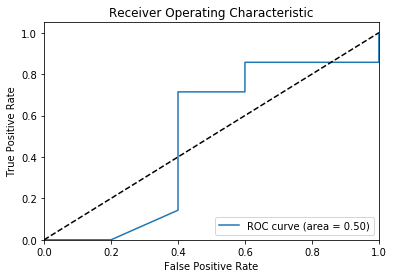

In [31]:
# Plotting the ROC curve from the results
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


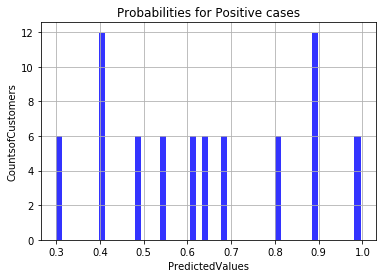

In [36]:
# Q9)Understand model’s performance, Plot the distribution of our predictions

all_prob_val = transformed.select("probability").collect()
pos_prob_val = [i[0][0] for i in all_prob_val]
neg_prob_val = [i[0][1] for i in all_prob_val]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(pos_prob_val, 50, normed=1, facecolor='blue', alpha=0.80)
plt.xlabel('PredictedValues')
plt.ylabel('CountsofCustomers')
plt.title('Probabilities for Positive cases')
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


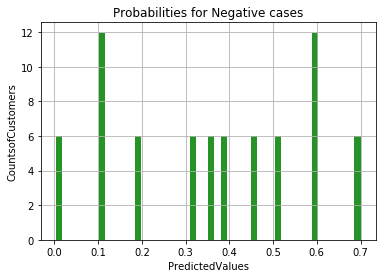

In [35]:
# neg
plt.hist(neg_prob_val, 50, normed=1, facecolor='green', alpha=0.85)
plt.xlabel('PredictedValues')
plt.ylabel('CountsofCustomers')
plt.title('Probabilities for Negative cases')
plt.grid(True)
plt.show()